### Script for reading data for Problem 4.2 (data_CountryScores.txt) in Applied Statistics 2023 problem set:

This script reads the file __"data_CountryScores.txt"__ for Problem 4.2 in the problem set of Applied Statistics 2023/24. This data files contains 133 entries in seven columns: 

* **Country**, Name of country
* **GDP**, Gross Domestic Product (per capita) of the country
* **Population Size**, of the country
* **Happiness index** of the country,
* **Economic Freedom index** of the country,
* **PressFreedom index** of the country,
* **Education index** of the country,

####  Author: 
- Troels Petersen (Niels Bohr Institute, petersen@nbi.dk)

####  Date:   
 - 14th of October 2023 (latest version)

In [28]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
import statistics 
from scipy import stats

In [12]:
dataframe = pd.read_csv('data_CountryScores.csv', header=0, index_col=None)
Country, GDP, PopSize, HappinessI, EconomicFreedomI, PressFreedomI, EducationI = dataframe.values.T
dataframe

,Country,GDP,PopSize,Happiness-index,EconomicFreedom-index,PressFreedom-index,Education-index
0,Afghanistan,592.0,18356000.0,2523.0,53.0,40.19,0.414
1,Albania,5837.0,2187000.0,5117.0,65.2,30.59,0.746
2,Algeria,3638.0,27620000.0,4887.0,49.7,47.26,0.672
3,Argentina,9929.0,30799000.0,5929.0,52.7,28.99,0.855
4,Armenia,4595.0,2176000.0,5283.0,71.9,28.83,0.740
...,...,...,...,...,...,...,...
128,Uruguay,16965.0,2530000.0,6431.0,69.3,16.38,0.765
129,Venezuela,1627.0,18359000.0,4892.0,24.7,47.60,0.700
130,Vietnam,3743.0,68565000.0,5411.0,61.7,78.46,0.630
131,Zambia,1115.0,8331000.0,4073.0,50.4,38.21,0.557


### 4.2 (14 points) The file www.nbi.dk/petersen/data CountryScores.csv contains a list of countries along with several key numbers and indices.

Determine the mean, median, standard deviation, 15.87%, and 84.13% quantiles of the GDP.

In [13]:
mean_GDP, median_GDP, std_GDP = GDP.mean(), statistics.median(GDP), GDP.std(ddof=1)
quant15_GDP, quant84_GDP = np.quantile(GDP, 0.1587), np.quantile(GDP, 0.8413)

print('GDP mean:', mean_GDP)
print('GDP median:', median_GDP)
print('GDP std:', std_GDP)
print('GDP 15.87% quantile:', quant15_GDP)
print('GDP 84.13% quantile:', quant84_GDP)

GDP mean: 17362.045112781954
GDP median: 6677.0
GDP std: 23840.252101659422
GDP 15.87% quantile: 1187.2259999999999
GDP 84.13% quantile: 40850.23440000002


Does the distribution of log10(PopSize) follow a Gaussian distribution?

In [14]:
log10_PopSize = np.log10(PopSize.tolist())

In [15]:
stats.kstest(log10_PopSize, 'norm') # if p<0.05 the distrubition is NOT gaussian

KstestResult(statistic=0.999999967873091, pvalue=0.0)

In [16]:
def plot_hist(ax, data, xlabel):
    # binwidth = (xmax - xmin) / Nbins
    Nbins = int(len(data) / 10)
    xmin, xmax = min(data), max(data)
    ax.hist(data, bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram')
    ax.set(xlabel=xlabel, ylabel="Count", xlim=(xmin-1.0, xmax+1.0))
    ax.legend(frameon = False)

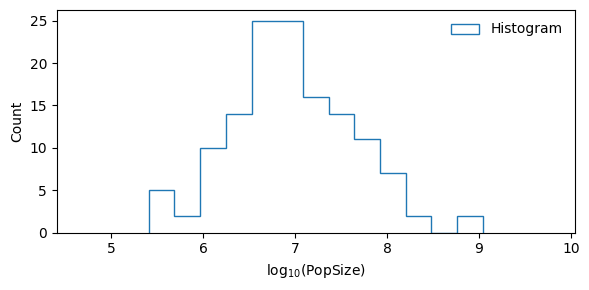

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (6, 3))

plot_hist(ax, log10_PopSize, r'log$_{10}$(PopSize)')

fig.tight_layout()
fig.savefig('log10_PopSize.png', dpi = 150)

What are the Pearson and Spearman correlations between happiness and education indeces?

In [20]:
pearson = stats.pearsonr(HappinessI, EducationI)
spearman = stats.spearmanr(HappinessI, EducationI)

print('Pearson correlation:', pearson[0])
print('Spearman correlation:', spearman[0])

Pearson correlation: 0.7647440306793953
Spearman correlation: 0.8043593869327467


Plot the Happiness-Index as a function of GDP, and fit the relation between the two. From this fit, what would you estimate the uncertainty to be on the Happiness-index?

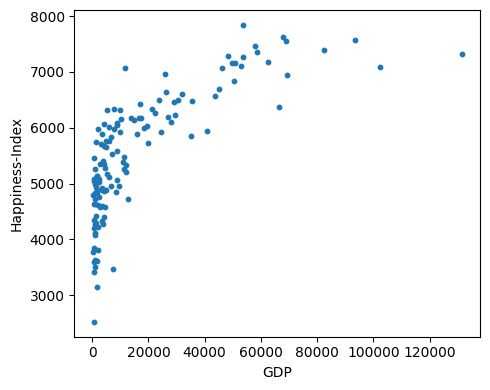

In [26]:
fig, ax = plt.subplots(figsize = (5, 4))

ax.scatter(GDP, HappinessI, s = 10) # Not a function i recognise
ax.set(xlabel = 'GDP', ylabel = 'Happiness-Index')

fig.tight_layout()
fig.savefig('HappinessI_vs_GDP.png', dpi = 150)

In [39]:
Minuit.print_level = 0

y = HappinessI
ey = np.ones_like(y)
x = np.log(GDP.tolist())

def fit_func(x, a, b):
    return a * x + b

# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(a, b) :
    y_fit = fit_func(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, a = 1000, b = 2000) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Prob_fit)

0.0


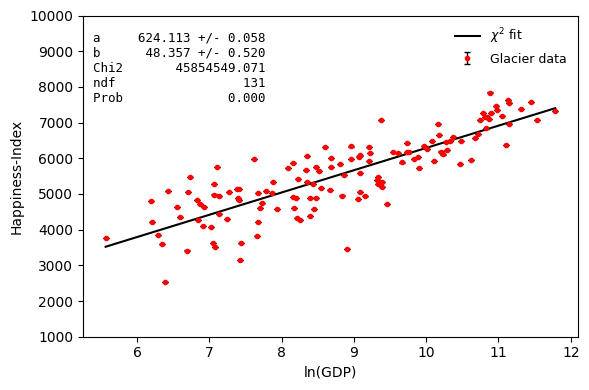

In [40]:
fig, ax = plt.subplots(figsize = (6, 4))

x_plot = np.linspace(min(x), max(x), 1000)

ax.plot(x_plot, fit_func(x_plot, *minuit.values[:]), '-k', zorder = -10, label = '$\chi^{2}$ fit')     # Note how we can "smartly" input the fit values!
ax.errorbar(x, y, ey, fmt = ".", color='r', ecolor='k', elinewidth=1, capsize=2, capthick=1, label = 'Glacier data')
ax.legend(frameon = False, fontsize = 9)

d = {'a':   [minuit.values[0], minuit.errors[0]],
     'b':   [minuit.values[1], minuit.errors[1]],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=9)

ax.set_ylabel('Happiness-Index')
ax.set_xlabel('ln(GDP)')
ax.set_ylim(1000, 10000)

fig.tight_layout()
fig.savefig('HappinessI_vs_logGDP_fit1.png', dpi = 150)

In [41]:
Minuit.print_level = 0

y = HappinessI
ey = np.ones_like(y) * (fit_func(x, *minuit.values[:]) - HappinessI).std(ddof = 1) # Assuming gaussian errors
print((fit_func(x, *minuit.values[:]) - HappinessI).std(ddof = 1))
x = np.log(GDP.tolist())

def fit_func(x, a, b):
    return a * x + b

# Alternatively, you can define Chi2 calculation:
def chi2_owncalc(a, b) :
    y_fit = fit_func(x, a, b)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, a = 1000, b = 2000) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Prob_fit)

589.3920151397442
0.45906107503732363


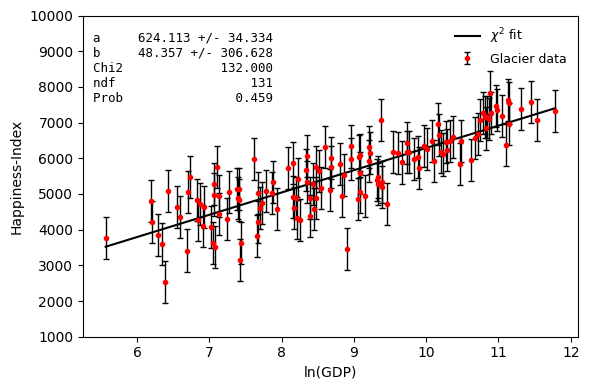

In [42]:
# Det antages at modellen i forvejen er korrekt, da man ikke kan teste den mere
# p-værdien siger ikke noget om hvor korrekt fitted er
# Denne måde at estimere errors på vil altid give en p-værdi på omkring 0.5
fig, ax = plt.subplots(figsize = (6, 4))

x_plot = np.linspace(min(x), max(x), 1000)

ax.plot(x_plot, fit_func(x_plot, *minuit.values[:]), '-k', zorder = -10, label = '$\chi^{2}$ fit')     # Note how we can "smartly" input the fit values!
ax.errorbar(x, y, ey, fmt = ".", color='r', ecolor='k', elinewidth=1, capsize=2, capthick=1, label = 'Glacier data')
ax.legend(frameon = False, fontsize = 9)

d = {'a':   [minuit.values[0], minuit.errors[0]],
     'b':   [minuit.values[1], minuit.errors[1]],
     'Chi2':     Chi2_fit,
     'ndf':      Ndof_fit,
     'Prob':     Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=9)

ax.set_ylabel('Happiness-Index')
ax.set_xlabel('ln(GDP)')
ax.set_ylim(1000, 10000)

fig.tight_layout()
fig.savefig('HappinessI_vs_logGDP_fit2.png', dpi = 150)